## Модули

In [42]:
import csv
import json
import itertools

import scipy as sp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from fa2 import ForceAtlas2
from matplotlib.pyplot import figure
from typing import Dict, List, Union, Tuple
from copy import deepcopy
from scipy.sparse import csc_matrix

%matplotlib inline

## Данные

Список смежности

In [2]:
with open("friends.json", "r") as f:
    data = json.load(f)
    
adj_list = {int(k): v for k, v in data.items()}

Метки для отрисовки графа

In [3]:
labels = {}

with open("friends.csv", mode="r") as f:
    reader = csv.reader(f)
    labels = {rows[0]:rows[1] for rows in reader}

labels = {int(k): v for k, v in list(labels.items())[1:]}
ego = list(labels.keys())[0]

## Обработка графа

**Список вершин**

In [4]:
def get_nodes(adj_list: Dict[int, List[int]]) -> List[int]:
    vals = list(adj_list.values())
    node_list = set(elem for sub in vals for elem in sub)
    node_list.add(list(adj_list.keys())[0])
    return list(node_list)

**Список рёбер**

In [5]:
def get_edges(adj_list: Dict[int, List[int]]) -> List[Tuple[int, int]]:
    edges = [list(itertools.product([k], v)) for k, v in adj_list.items()]
    flatten = [elem for sub in edges for elem in sub]
    return [(a, b) for a, b in flatten if not ((b, a) in flatten and b > a)]

**Матрица смежности**

In [6]:
def get_adj_matrix(adj_list: Dict[int, List[int]]) -> List[List[Union[float, int]]]:
    nodes = get_nodes(adj_list)
    n = len(nodes)
    matrix = [[0 for j in range(n)] for i in range(n)]
    codes = dict(zip(nodes, range(n)))
    for key, val in adj_list.items():
        for node in val:
            matrix[codes[key]][codes[node]] = 1
            matrix[codes[node]][codes[key]] = 1
    return matrix

In [7]:
g = nx.Graph(adj_list)

## Алгоритмы

__Алгоритм Флойда-Уоршелла__

In [8]:
def adj_floyd_warshall(adj_matrix: List[List[int]]) -> List[List[int]]:
    n = len(adj_matrix)
    new_matrix = deepcopy(adj_matrix)
    
    for i in range(n):
        for j in range(n):
            if new_matrix[i][j] == 0 and i != j:
                new_matrix[i][j] = float("inf")

    return new_matrix

In [9]:
def floyd_warshall(adj_matrix: List[List[int]]):
    n = len(adj_matrix)
    new_matrix = adj_floyd_warshall(adj_matrix)
    dist = list(map(lambda i: list(map(lambda j: j, i)), new_matrix))
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j],
                                 dist[i][k] + dist[k][j])
    return dist

### Network Distribution

__Degree Centrality__

В метрике `Degree Centrality` важность узла определяется тем, с каким количеством узлов он связан. Это измерение количества прямых связей с другими участниками сети. Это означает, что чем больше число смежных узлов, тем важнее узел, поскольку он не зависит от других участников, которые достигают больших частей сети. Это локальная мера, поскольку ее значение рассчитывается на основе количества связей субъекта с другими субъектами, непосредственно примыкающими к нему. Субъекты в социальных сетях с высокой степенью центральности выступают в качестве узлов и основных каналов передачи информации.

$$d(i)=\sum_{j}m_{ij}$$, где $m_{ij}=1$ если есть связь между вершинами $i$ и $j$, $m_{ij}=0$ в противном случае.

In [10]:
def degree_centrality(adj_list: Dict[int, List[int]]) -> Dict[int, int]:
    degree = dict()
    nodes = get_nodes(adj_list)
    edges = get_edges(adj_list)
    for node in nodes:
        degree[node] = 0
        for edge in edges:
            if node in edge:
                degree[node] += 1
    return degree

In [11]:
# degree_centrality(adj_list)

In [12]:
# g.degree()

__Closeness Centrality__

`Closeness Centrality` можно определить как то, насколько близко к определенному субъекту находятся другие субъекты. Это сумма геодезических расстояний узла до всех других узлов сети. Она вычисляет длину путей от одного агента к другим агентам в сети.

$$C(i) = \sum_{j}d_{ij}$$, где $d_{ij}$ это геодезическоре расстояние из узла $i$ в узел $j$.

`Closeness Centrality` важна для понимания распространения информации в сетях в том смысле, что расстояние между одним конкретным узлом и другими влияет на то, как этот узел может получать от других узлов или отправлять им информацию (например, сплетни).

In [13]:
def closeness_centrality(adj_list: Dict[int, List[int]]) -> Dict[int, int]:
    adj_matrix = get_adj_matrix(adj_list)
    fw = floyd_warshall(adj_matrix)
    nodes = get_nodes(adj_list)
    n = len(nodes)
    codes = dict(zip(range(n), nodes))
    
    closeness = {node: 0 for node in nodes}
    
    for i in range(n):
        closeness[codes[i]] = (n-1)/sum(fw[i])
        
    return closeness

In [14]:
# closeness_centrality(adj_list)

In [15]:
# nx.closeness_centrality(g)

__Eccentricity__

`Eccentricity` $-$ это максимальное расстояние от данного узла до всех остальных узлов сети. `Eccentricity` $-$ это популярная мера, основанная на пути, которая дает значение каждому узлу в сети на основе его прямых и косвенных связей.

$$E(u) = \max_{v \in V} d(u,v)$$

In [16]:
def eccentricity(adj_list: Dict[int, List[int]]) -> Dict[int, int]:
    adj_matrix = get_adj_matrix(adj_list)
    fw = floyd_warshall(adj_matrix)
    nodes = get_nodes(adj_list)
    n = len(nodes)
    codes = dict(zip(range(n), nodes))
    
    eccentricity = {node: 0 for node in nodes}
    
    for i in range(n):
        eccentricity[codes[i]] = max(fw[i])
        
    return eccentricity

In [17]:
# eccentricity(adj_list)

In [18]:
# nx.eccentricity(g)

## Network Measurements

__Network Density__

`Network Density` как степень, в которой узлы сети связаны один с другим. Она может использоваться как мера того, насколько сеть близка к полной. В случае полного графа (графа, в котором присутствуют все возможные ребра) плотность равна единице. В реальной жизни плотная группа объектов имеет много связей между своими сущностями (т.е. имеет высокую плотность), а разреженная группа - мало (т.е. имеет низкую плотность).

In [19]:
def network_density(adj_list: Dict[int, List[int]]) -> int:
    m = len(get_edges(adj_list))
    n = len(get_nodes(adj_list))
    return 2*m/(n*(n-1))

In [20]:
network_density(adj_list)

0.13885361871939053

In [21]:
nx.density(g)

0.13885361871939053

__Average Degree__

`Average Degree` $-$ средняя степень вершины в сети.

In [22]:
def average_degree(adj_list: Dict[int, List[int]]) -> int:
    degree = degree_centrality(adj_list)
    return sum(degree.values())/len(degree.keys())

In [23]:
average_degree(adj_list)

20.550335570469798

In [24]:
sum(dict(g.degree()).values())/len(dict(g.degree()).keys())

20.550335570469798

__Average Shortest Path__

`Average Shortest Path` $-$ средняя длина пути в сети.

In [25]:
def average_shortest_path_length(adj_matrix: List[List[Union[float, int]]]) -> int:
    n = len(adj_matrix)
    fw = floyd_warshall(adj_matrix)
    return sum(map(sum, fw))/(n*(n-1))

In [26]:
adj_matrix = get_adj_matrix(adj_list)
average_shortest_path_length(adj_matrix)

1.8611463812806095

In [27]:
nx.average_shortest_path_length(g)

1.8611463812806095

__Network Diameter__

`Network Diameter` $-$ диаметр сети.

In [28]:
def network_diameter(adj_matrix: List[List[Union[float, int]]]) -> int:
    fw = floyd_warshall(adj_matrix)
    return max(map(max, fw))

In [29]:
adj_matrix = get_adj_matrix(adj_list)
network_diameter(adj_matrix)

2

In [30]:
nx.diameter(g)

2

## Отрисовка

In [31]:
forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=0.1,
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=12.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2829.69it/s]


BarnesHut Approximation  took  0.18  seconds
Repulsion forces  took  0.38  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


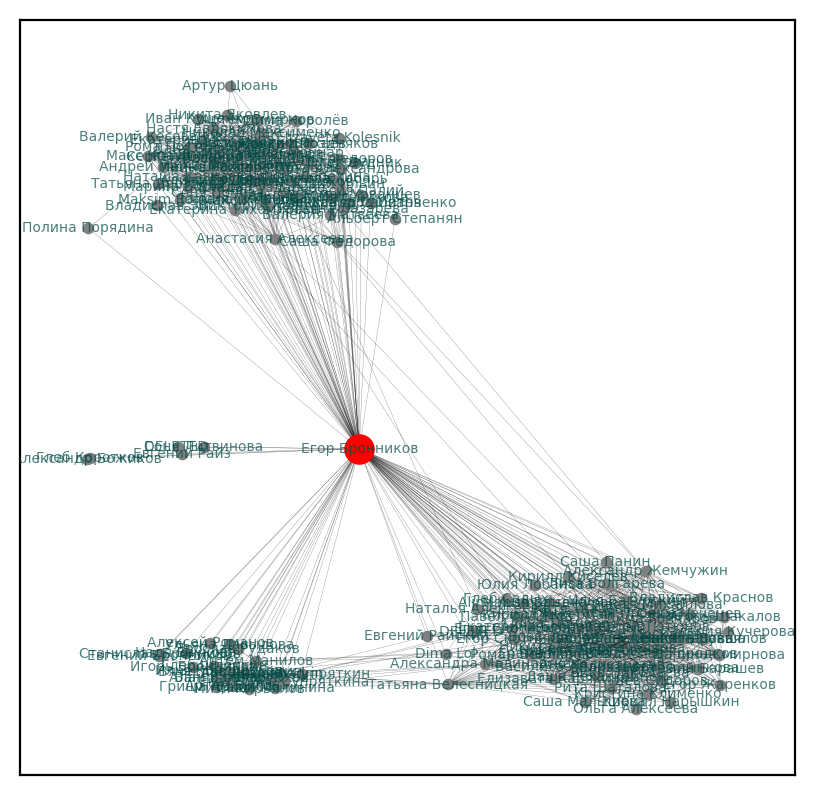

In [52]:
figure(figsize=(5,5), dpi=200)
positions = forceatlas2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)
nx.draw_networkx_nodes(g, positions, node_size=10, node_color="gray")
nx.draw_networkx_nodes(g, positions, node_size=100, nodelist=[ego], node_color="red")
nx.draw_networkx_edges(g, positions, edge_color="black", alpha=0.6, width=0.1)
nx.draw_networkx_labels(g, positions, labels=labels, font_size=5, font_color="#004a46", alpha=0.7)
plt.show()

In [49]:
# pr = nx.pagerank(g, alpha=0.9)